Problem of *Image regression*:
- Independent variable: an Image
- Dependent variable: one or more floats

We can treat image regression as just another CNN on top of the data block API.

Do a key point model: refers to a specific location represented in an image
- looking for the center of the person's face in each image
- actually predicting two values for each image: the row and column of face center

In [1]:
from fastai.vision.all import *

## Assembling the Data

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [3]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/21'),Path('/root/.fastai/data/biwi_head_pose/readme.txt'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/17')...]

There are 24 directories numbered from 01 to 24 and a corresponding .obj file for each

In [4]:
# look inside one of these directories:

(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00230_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00176_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00016_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00349_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00181_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00263_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00077_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00137_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00469_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00009_pose.txt')...]

Inside the subdirectories, we have different frames:
- an Image (_rgb.jpg)
- a Pose file (_pose.txt)

In [5]:
# get all the image files recursively:
img_files = get_image_files(path)

# converts an image file to its associated pose file:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/04/frame_00596_pose.txt')

In [6]:
# look at our first image:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

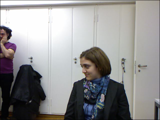

In [7]:
im.to_thumb(160)

In [8]:
# extract the head center point:

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[0] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [9]:
# this functions returns the coordinates as a tensor of two items:
get_ctr(img_files[0])

tensor([358.8638, 279.3638])

Pass this fn to DataBLock as get_y(labeling each item). To speed up training, resize the images to half their input size.

Create a splitter func that returns True for just one person, resulting in a validation set containing just that person's images.

Second block is a PointBlock: fastai knows that the labels represent coordinates

In [10]:
# do the same augmentation to these coordinates as it does to the images:

biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


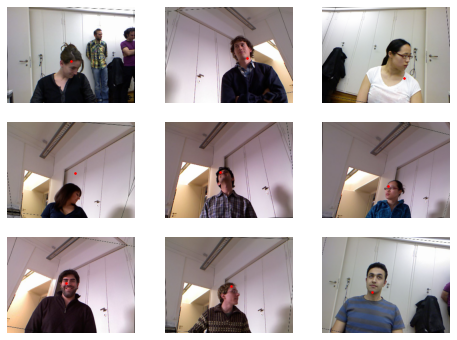

In [11]:
# before modeling, look at data to confirm it seems OK:

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [12]:
# it's a good idea to also look at the underlying tensors:

xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [13]:
# example of one row from the dependent variable:
yb[0]

TensorPoint([[ 0.0118, -0.1049]], device='cuda:0')

### Training a Model

In [14]:
# we used y_range to tell fastai the range of our targets
# coordinates in fastai and PyTorch are always rescaled between -1 and +1:

learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
# y_range is implemented in fastai using sigmoid_range, define as follows:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [16]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  


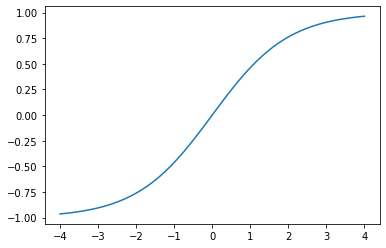

In [17]:
# it forces the model to output activations in the range (lo,hi)
# what it looks like:

plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss fn, so fastai chooses as the default

In [18]:
# see what it picked for us:

dls.loss_func

FlattenedLoss of MSELoss()

when coordinates are used as the dependent variable, most of the time we're likely to be tring to predict something as close as possible: basic MSELoss does.

We didn't specify any metrics. MSE is useful metric for this task.

SuggestedLRs(valley=0.001737800776027143)

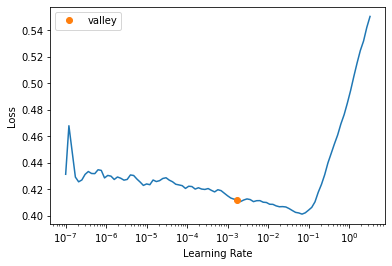

In [19]:
# pick a good learning rate with the learning rate finder:
learn.lr_find()

In [20]:
# try an LR of 2e-2:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.050481,0.006685,02:42
1,0.007768,0.000549,02:41
2,0.003594,0.000919,02:43
3,0.002651,0.000301,02:39
4,0.001952,0.000209,02:41


In [21]:
# when run this, get loss of around 0.0001, which corresponds to this average coordinate prediction error:
math.sqrt(0.0001)

0.01

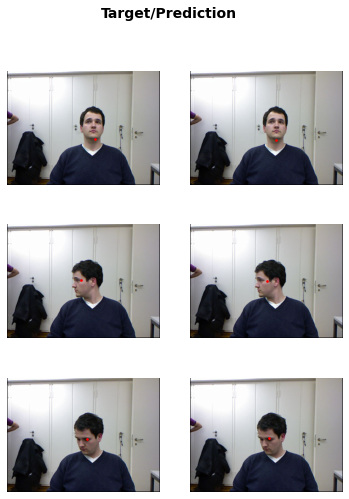

In [22]:
# look at our results
# LHS: actual(ground truth) coordinates
# RHS: model's predictions:

learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

- nn.CrossEntropyLoss for single-label classification
- nn.BCEWithLogitsLoss for multi-label classification
- nn.MSELoss for regression